In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('Data/boston.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


### Data cleaning

to-dos:
    - convert split times to float
    - drop ctz, name, city
    - gender to int (1=female, 0=male)
    - normalize continuous data
    - PCA for visualization

In [3]:
# Convert split times to float

splits = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']

for s in splits:
    df.loc[:,s] = pd.to_numeric(df[s],errors='coerce')

In [4]:
# Drop features we will not use

df.drop(['ctz', 'name', 'city'], axis=1, inplace=True)

In [5]:
# Gender to binary int

df.loc[:,'gender'] = np.where(df['gender'] == 'F', 1, 0)

In [6]:
from sklearn.preprocessing import normalize

In [7]:
X = df.select_dtypes('float64').dropna()
X_norm = normalize(X)

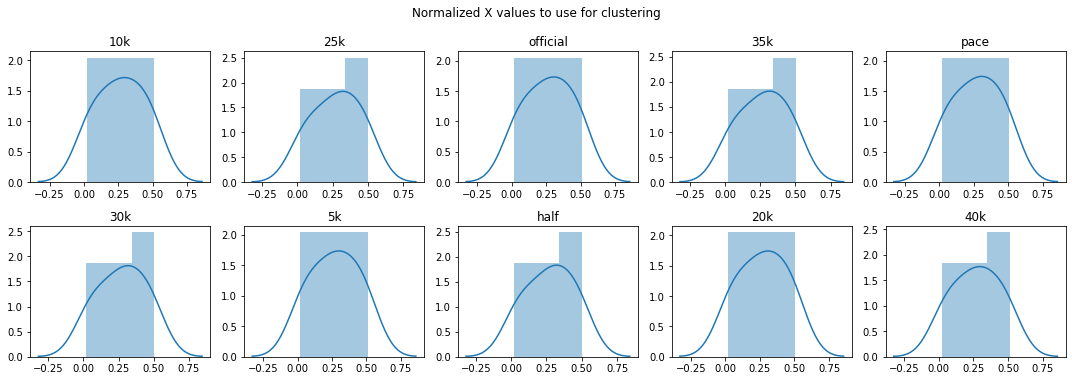

In [9]:
plt.figure(figsize=(15,5))

for i in range(X_norm.shape[1]):
    plt.subplot(2,5,i+1)
    sns.distplot(X_norm[i])
    plt.title(X.columns[i])

plt.suptitle('Normalized X values to use for clustering', y=1.05) 
plt.tight_layout()
plt.show()

In [8]:
from sklearn.decomposition import PCA

In [9]:
# Need to drop values to create 4 equal test splits

rows = (X.shape[0] - (X.shape[0])%4)
X_norm = X_norm[:rows, :]
print('n samples in X_norm: ' + str(X_norm.shape[0]))

n samples in X_norm: 31648


In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

### Split data into 4 subsets for evaluation

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Split data into halves

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_norm, X_pca, test_size=0.5, random_state=2)

In [13]:
# Split halves into quarters

X1, X2, pca1, pca2 = train_test_split(X_half1, X_pcahalf1, test_size=0.5, random_state=2)
X3, X4, pca3, pca4 = train_test_split(X_half2, X_pcahalf2, test_size=0.5, random_state=2)

### Model using kmeans

In [14]:
from sklearn.cluster import KMeans

In [15]:
# Check sizes of data splits

for data in [
    (X1, pca1),
    (X2, pca2),
    (X3, pca3),
    (X4, pca4)]:
    print(len(data[0]), len(data[1]))

7912 7912
7912 7912
7912 7912
7912 7912


In [18]:
# Create df to save results

ypred = pd.DataFrame()

for counter, data in enumerate([
    (X1, pca1),
    (X2, pca2),
    (X3, pca3),
    (X4, pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in [2,4,6]:
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

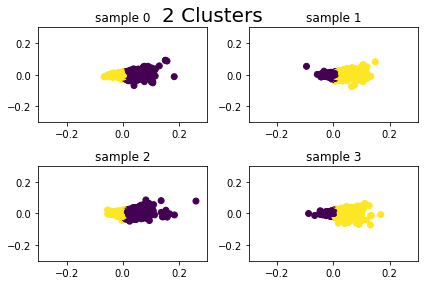

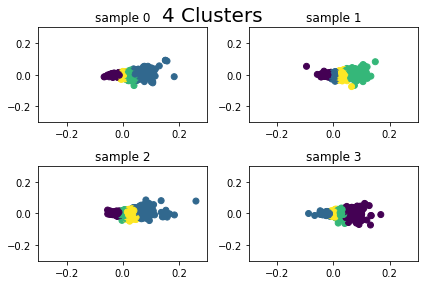

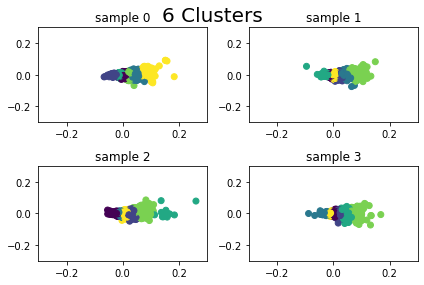

In [19]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in [2,4,6]:
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

2 clusters seems to be the most consistent across the 4 samples, let's print out the means and ranges of silhoutte scores for a range of clusters to determine the best choice.

In [20]:
from sklearn.metrics import silhouette_score
from statistics import mean

In [21]:
for i in range(2,7):
    km_scores = []
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=i, random_state=42).fit(sample)
        labels = model.labels_
        km_scores.append(silhouette_score(sample, labels, metric='euclidean'))

    print('n_clusters: ' + str(i))
    print('Average score across the samples: ' + str(mean(km_scores)))
    print('Range of scores across the samples: ' + str(max(km_scores) - min(km_scores)) + '\n')

n_clusters: 2
Average score across the samples: 0.523825835726969
Range of scores across the samples: 0.011291062975894994

n_clusters: 3
Average score across the samples: 0.4504339836063947
Range of scores across the samples: 0.011541434016916874

n_clusters: 4
Average score across the samples: 0.4032962428311081
Range of scores across the samples: 0.025254749370867136

n_clusters: 5
Average score across the samples: 0.3622458660105429
Range of scores across the samples: 0.009359807226958061

n_clusters: 6
Average score across the samples: 0.33414915998362904
Range of scores across the samples: 0.03421030353170834



It is apparent that as the number of clusters increases, we get a decrease in silhoutte scores. The range of scores stays fairly consistent with the lowest value occuring at 5 clusters; however, this value is only ~.002 lower than the 2 cluster model. Therefore we will proceed with only 2 clusters for kmeans. Let's try some other clustering methods to try and improve performance. 

## Other clustering methods

In [17]:
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation

### Mean shift

In [144]:
ms_scores = []
for sample in [X1, X2, X3, X4]:
    bw = estimate_bandwidth(sample, quantile=0.2)
    model = MeanShift(bandwidth=bw, bin_seeding=True).fit(sample)
    ms_labels = model.labels_
    ms_scores.append(silhouette_score(sample, labels, metric='euclidean'))
    i = model.cluster_centers_.shape[0]

print('n_clusters: ' + str(i))
print('Average score across the samples: ' + str(mean(ms_scores)))
print('Range of scores across the samples: ' + str(max(ms_scores) - min(ms_scores)) + '\n')

n_clusters: 46
Average score across the samples: 0.04558873018796228
Range of scores across the samples: 0.4142916574156218



### Spectral Clustering

In [147]:
sc_scores = []
for sample in [X1, X2, X3, X4]:
    model = SpectralClustering(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    sc_scores.append(silhouette_score(sample, labels, metric='euclidean'))
    
print('n_clusters: ' + str(2))
print('Average score across the samples: ' + str(mean(sc_scores)))
print('Range of scores across the samples: ' + str(max(sc_scores) - min(sc_scores)) + '\n')

n_clusters: 2
Average score across the samples: 0.5242512035131779
Range of scores across the samples: 0.010289890218379005



### Affinity Propagation

In [24]:
ap_scores = []
for sample in [X1, X2, X3, X4]:
    model = AffinityPropagation().fit(sample)
    labels = model.labels_
    ap_scores.append(silhouette_score(sample, labels, metric='euclidean'))
    n_clusters = model.cluster_centers_.shape[0]

print('n_clusters: ' + str(n_clusters))
print('Average score across the samples: ' + str(mean(ap_scores)))
print('Range of scores across the samples: ' + str(max(ap_scores) - min(ap_scores)) + '\n')

n_clusters: 154
Average score across the samples: 0.14466715368126765
Range of scores across the samples: 0.010787361179934285



The best performance came from the Spectral Clustering method with 2 clusters, although K-means with 2 clusters performed nearly the same. Both affinity propagation and mean shift performed quite poorly on this dataset.